# Purpose of this notebook:

This notebook explains the calculations related to the cylindrical tube running through the spindle of the mechanism. This tube serves a couple purposes:

1. It guides the feedstock wire from the extruder to the nozzle.
2. It constrains the rotary degree of freedom of the shaft supporting the nozzle.

Due to the eccentricity of the lower spindle body, the nozzle shaft will follow a circular path, and the tube must be able to bend to accomodate this deflection. Several factors impact whether the tube will accomodate the deflection:

1. The material and its constants such as Young's modulus (elasticity) and yield strength (stress required to begin permanently deforming the material).
2. The geometry such as length, inner diameter, and outer diameter.

We will approach this problem using shear and moment diagrams and beam bending theory.

# Step 1: Choosing material properties and some geometry

To make things a little easier for ourselves (and keep the optimization simple), let's define a couple things now. There are only so many standard size tubes, and only so many standard materials for these tubes, so I am going to pick these based on experience. These can always change depending on the design! Here I will choose the material to be 304 stainless steel, and the tube to have an inner and outer diameter of 1mm and 3mm, respectively.

The material properties for the steel was found here: https://matweb.com/search/DataSheet.aspx?MatGUID=abc4415b0f8b490387e3c922237098da&ckck=1

We will be using metric units for these calculations.

In [67]:
E = 193e9     # [Pa] - Modulus of Elasticity (AKA Young's Modulus) for 304 stainless steel
ys = 215e6    # [Pa] - Yield Strength
id = 1e-3     # [m] - Inner diameter of tube
od = 3e-3     # [m] - Outer diameter of tube

# Step 2: Calculating the area moment of inertia

Beams are an engineering simplification that have been used to great effect. When material being bent is much longer compared to its other dimensions, we can make some neat simplifications. Euler (the mathematician) gets all the credit, as usual. In our case, the length of the tube will probably be an order of magnitude greater than any of its other dimensions, particularly the outer diameter. This is an indicator we can use beam theory to determine stresses.

To use beam theory, we need to calculate a number known as the area moment of inertia _I_, which is related to the cross section of the beam. The area moment of inertia describes how material is distributed around its bending axis. A larger number means that more material is spread farther from the bending axis, and the beam will be more stiff. Formulas have been developed for different simple cross sections, including an annulus (AKA tube). The following image and formula were taken from this website: https://www.engineersedge.com/calculators/section_square_case_12.htm

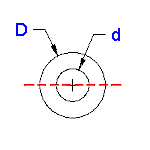

$$ I = \pi (D^4 - d^4)/64 $$

In [68]:
pi = 3.1415
I = pi*(od**4 - id**4)/64 # Calculating area moment of inertia for a tube

# Step 3: Beam rotation and deflection to determine loads

We know that the tube will have to deflect an amount equal to the eccentricity of the spindle. It will also return to being straight at the end. Typically we determine the deflection and rotation of a beam based on the load, but we can also work in reverse, as is the case here. We need to know the loads present within the beam to achieve the desired deflection, that way we can later check whether the stresses caused by these forces and moments are satisfactory.

The beam bending equations were found at this website: https://civilengineerspk.com/wp-content/uploads/2014/05/1399860224-Beamdeflec-o.jpg
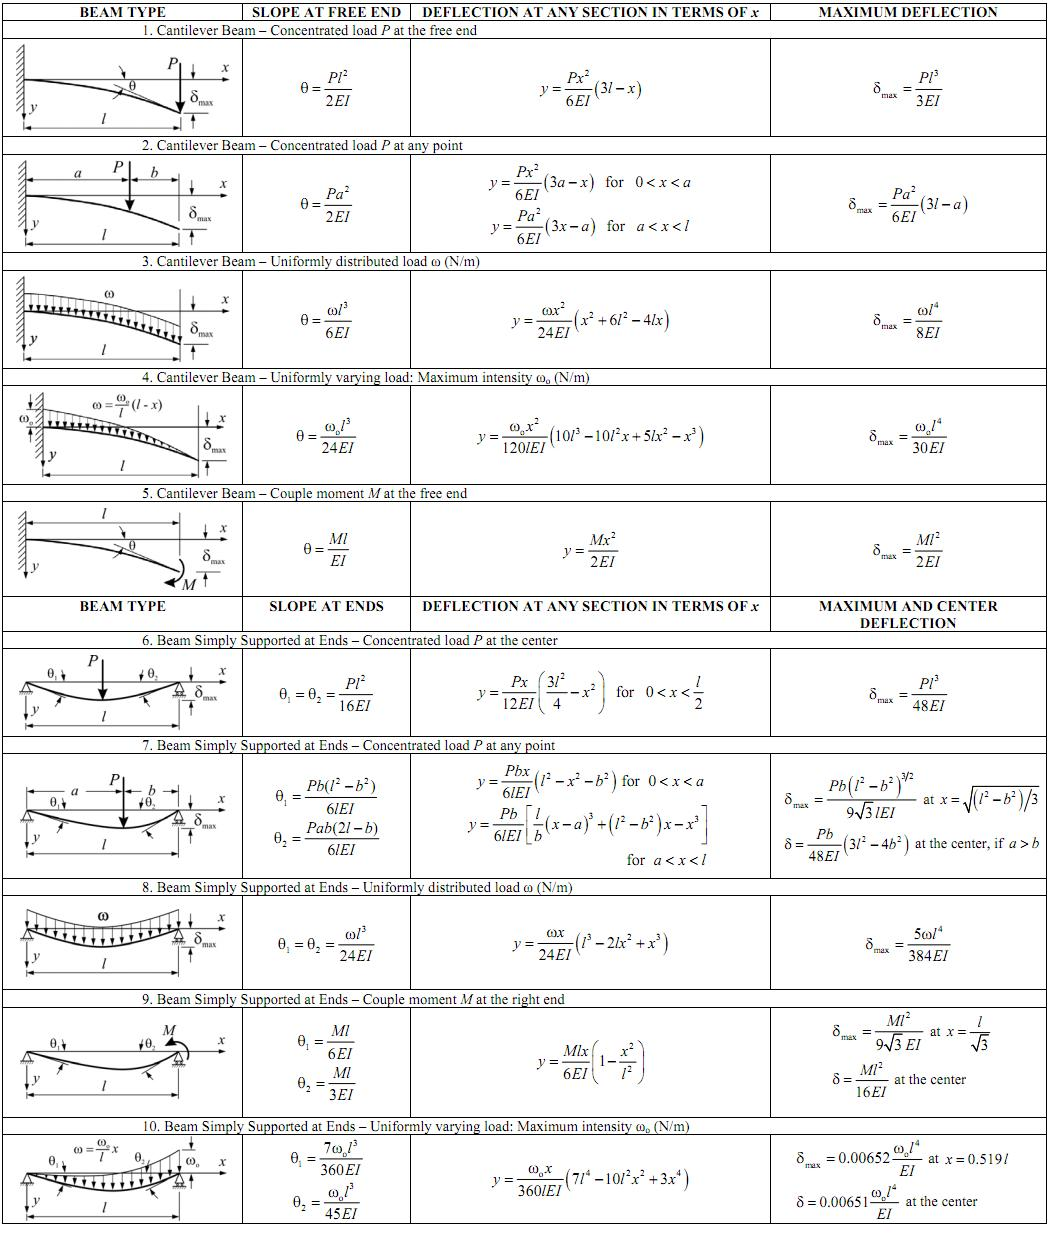

From beam type 1, we have the equations for deflection and rotation of the free end:
$$ \delta_1 = \frac{Pl^3}{3EI} \;\;\;\;\; \theta_1 = \frac{Pl^2}{2EI} $$ 

From beam type 5, we also have the equations for deflection and rotation of the free end:
$$ \delta_5 = \frac{Ml^2}{2EI} \;\;\;\;\; \theta_5 = \frac{Ml}{EI} $$

Due to the linear nature of these equations (thanks to the small strain assumption), we can add these equations. We know that the sum of the two deflections must be equal to the eccentricity, and we know that the sum of the rotations must be equal to zero:
$$ \delta_1 + \delta_5 = \frac{Pl^3}{3EI} + \frac{Ml^2}{2EI} = \delta_{ecc} $$
$$ \theta_1 + \theta_5 = \frac{Pl^2}{2EI} + \frac{Ml}{EI} = 0 $$

Two equations, two unknowns. This can be solved as a system of linear equations:
$$ P = \frac{12EI\delta_{ecc}}{l^3} \;\;\;\;\; M = \frac{-6EI\delta_{ecc}}{l^2} $$

In [69]:
d_ecc = 0.5e-3 # [m] - Eccentricity of the spindle

# We will create a function that takes in the the beam parameters and spits out a force and moment.
def getLoads(eccentricity, elasticity, areaMomentInertia, length):
    force = 12 * elasticity * areaMomentInertia * eccentricity / length**3
    moment = -6 * elasticity * areaMomentInertia * eccentricity / length**2
    return force, moment

# Test out the function on some dummy lengths
testLength = 75e-3

[testForce, testMoment] = getLoads(d_ecc, E, I, testLength)
print("Test force: %f N    Test moment: %f Nm" % (testForce, testMoment))


Test force: 10.778836 N    Test moment: -0.404206 Nm


# Step 4: Determine the maximum moment on the tube

The location of maximum bending moment will occur at either the LHS or RHS of the tube, since the situation is symmetric. The force will cause a constant shear stress throughout the beam. Note that the maximum moment will be equal to the moment we calculated for the free end of the beam, so we can use this value later.

In [70]:
# Calculate the bending moment at the LHS of the tube caused by the force
M_P = testForce*testLength
# This is then added to the end moment
M_final = M_P + testMoment

print("Moment at the LHS: %f Nm" % M_final)

Moment at the LHS: 0.404206 Nm


# Step 5: Determine the stress at the outer edge of the tube

There are two stresses on the tube. The first is the bending moment stress, caused by the bending moment (obviously). The maximum stress contribution is calculated as:
$$ \sigma_{max} = \frac{Mc}{I} $$
In this case, _M_ is the moment and _c_ is the distance from the bending axis to the outer edge of the cross section, in this case the outer radius.

There is also a contribution from the shear stress. This one is easier, and is just the definition of stress, or:
$$ \tau = \frac{4P}{\pi(D_{outer}^2-D_{inner}^2)} $$

In [71]:
def getStresses(shearForce, bendingMoment, outerDiameter, innerDiameter, areaMomentInertia):
    shearStress = (4 * shearForce) / (pi * (outerDiameter**2 - innerDiameter**2))
    bendingStress = bendingMoment * 0.5 * outerDiameter / areaMomentInertia
    return shearStress, bendingStress

[shearStress, bendingStress] = getStresses(testForce, abs(testMoment), od, id, I)
print("Maximum bending stress: %f MPa     Maximum shear stress: %f MPa" % (bendingStress/1000000, shearStress/1000000))

Maximum bending stress: 154.400000 MPa     Maximum shear stress: 1.715556 MPa


# Step 6: Wrap everything together

1. Determine the maximum stress that you can accept in the tube. This will be some function of the yield stress and the desired factor of safety.
2. Use the maximum stress formula to determine the maximum acceptable moment.
3. Use the equation relating the elasticity, area moment of inertia, eccentricity, and moment to calculate the minimum length of tubing needed to meet the stress requirement.

In [72]:
safetyFactor = 2

sigmaMax = ys/safetyFactor
momentMax = sigmaMax*I/(od/2)
lengthMin = ((6*E*I*d_ecc)/momentMax)**0.5